# Ridge Regression on Boston Housing Dataset
*This notebook builds ridge regression models for predicting housing prices in Boston.*

## Import Dependencies

In [1]:
import numpy as np
import scipy
from collections import defaultdict
import peak_engines
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Prepare Dataset

In [2]:
X, y = load_boston(return_X_y=True)
X = StandardScaler().fit_transform(X)
y /= np.std(y)

## Set up a validation simulation

In [3]:
def validate_models(X, y, models, n, num_trials):
    result = defaultdict(list)
    for _ in range(num_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n)
        for name, model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            result[name].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return result

def run_simulation(X, y, models, train_sizes, num_trials):
    result = defaultdict(lambda: defaultdict(list))
    for n in train_sizes:
        for name, errors in validate_models(X, y, models, n, num_trials).items():
            mean = np.mean(errors)
            stddev = np.std(errors, ddof=1)
            interval = scipy.stats.t.interval(alpha=0.95, df=num_trials-1, 
                                              scale=stddev/np.sqrt(num_trials))
            result[name]['mean'].append(mean)
            result[name]['error_bar'].append(interval[1])
    return result

## Run validation simulation

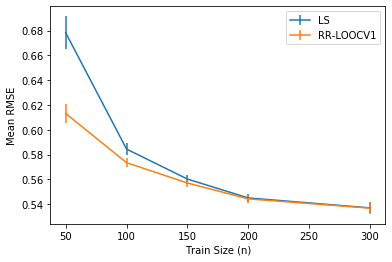

In [4]:
np.random.seed(0)
models = [
    ('LS', LinearRegression()),
    ('RR-LOOCV1', peak_engines.RidgeRegressionModel()),
        # Use a single regularizer for all regressors set so as to minimize the 
        # leave-one-out cross-validation error on the training dataset
]
train_sizes = [50, 100, 150, 200, 300]
num_trials = 300
simulation_results = run_simulation(X, y, models, train_sizes, num_trials)

for name, simulation_result in simulation_results.items():
    plt.errorbar(train_sizes, 
                 simulation_result['mean'], 
                 yerr=simulation_result['error_bar'], 
                 label=name)
plt.legend(loc='upper right')
plt.xlabel('Train Size (n)')
plt.ylabel('Mean RMSE')
plt.show()